In [2]:
import lxml.html as lh
import time
import pandas as pd
import urllib.request
import argparse
import datetime
import pytz
from selenium import webdriver
from selenium.common.exceptions import StaleElementReferenceException
import os
import coloredlogs

from docopt import docopt
from trading_bot.ops import get_state
from trading_bot.agent import Agent
from trading_bot.methods import evaluate_model
from trading_bot.utils import (
    get_stock_data,
    format_currency,
    format_position,
    show_eval_result,
    switch_k_backend_device
)




tz = pytz.timezone('Asia/Kolkata')

path1 = os.getcwd()
path = path1 + '/chromedriver'

ignored_exceptions=(StaleElementReferenceException,)
options = webdriver.ChromeOptions()
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument('--headless')
options.add_experimental_option('excludeSwitches', ['enable-logging'])
#options.add_argument(f'user-agent={userAgent}')
driver = webdriver.Chrome(executable_path=path , options=options)



#This function returns the table of the given url
def Real(url,count):
    if count == 0:
        
        driver.get(url)
        #print(driver)

    else:
        driver.refresh()
        time.sleep(15)

    infile = driver.page_source
    doc = lh.fromstring(infile)
    live = doc.xpath('/html/body/div[1]/div/div/div[1]/div/div[2]/div/div/div[4]/div/div/div/div[3]/div/div/span[1]')
    live = float(live[0].text.replace(',',''))
    return live 

def main(args):
    count = 0
    total_profit = 0
    t=0
    history = []
    reward = 0
    ticker = args.ticker + '.NS'
    price = []
    window_size =10
    time_now = datetime.datetime.now(tz).time()
    while(datetime.time(9, 14, tzinfo=tz) < time_now < datetime.time(15, 31, tzinfo=tz)):
        url = 'https://finance.yahoo.com/quote/{}?p={}&.tsrc=fin-srch'.format(ticker,ticker)
        print(count)
        live = Real(url,count)
        count+=1        
        price.append(live)
        if count < window_size:
           continue
        model_name='model_debug_50'  
        print(live)
        initial_offset = price[1] - price[0]
        state = get_state(price, 0, window_size + 1)
        next_state = get_state(price, t + 1, window_size + 1)
        agent = Agent(state_size=window_size, pretrained=True, model_name=model_name)
        agent.inventory = []
        profit = evaluate_model(agent,state,next_state, price, t, total_profit, history, reward, window_size=window_size)
        show_eval_result(model_name, profit, initial_offset)
        t+=1
        state = next_state
def evaluate_model(agent, state, next_state, data, t, total_profit, history, reward, window_size, debug=False):
  
    print(t)
        # select an action
    action = agent.act(state, is_eval=True)

        # BUY
    if action == 1:
        agent.inventory.append(data[t])

        history.append((data[t], "BUY"))
        if debug:
            logging.debug("Buy at: {}".format(format_currency(data[t])))

        # SELL
    elif action == 2 and len(agent.inventory) > 0:
        bought_price = agent.inventory.pop(0)
        delta = data[t] - bought_price
        reward = delta #max(delta, 0)
        total_profit += delta

        history.append((data[t], "SELL"))
        if debug:
            logging.debug("Sell at: {} | Position: {}".format(
                    format_currency(data[t]), format_position(data[t] - bought_price)))
        # HOLD
    else:
        history.append((data[t], "HOLD"))

#        done = (t == data_length - 1)
    agent.memory.append((state, action, reward, next_state))

    return total_profit

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('ticker', help = 'ticker')
    args = parser.parse_args()

    coloredlogs.install(level="DEBUG")
    switch_k_backend_device()

    try:
        main(args)
    except KeyboardInterrupt:
        print("Aborted")    

ModuleNotFoundError: No module named 'trading_bot'

In [7]:
df = pd.read_csv('trading_RL_yahoo/data/GOOG_2019.csv')

In [8]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,1016.570007,1052.319946,1015.710022,1045.849976,1045.849976,1532600
1,2019-01-03,1041.000000,1056.979980,1014.070007,1016.059998,1016.059998,1841100
2,2019-01-04,1032.589966,1070.839966,1027.417969,1070.709961,1070.709961,2093900
3,2019-01-07,1071.500000,1074.000000,1054.760010,1068.390015,1068.390015,1981900
4,2019-01-08,1076.109985,1084.560059,1060.530029,1076.280029,1076.280029,1764900
...,...,...,...,...,...,...,...
246,2019-12-23,1355.869995,1359.800049,1346.510010,1348.839966,1348.839966,883100
247,2019-12-24,1348.500000,1350.260010,1342.780029,1343.560059,1343.560059,347500
248,2019-12-26,1346.170044,1361.327026,1344.469971,1360.400024,1360.400024,667500
249,2019-12-27,1362.989990,1364.530029,1349.310059,1351.890015,1351.890015,1038400


In [21]:
df = pd.read_csv('trading_RL_yahoo/data/GOOG_2019.csv')
# filter out the desired features
df = df[['Date', 'Adj Close']]
# rename feature column names
df = df.rename(columns={'Adj Close': 'actual', 'Date': 'date'})
# convert dates from object to DateTime type
dates = df['date']
dates = pd.to_datetime(dates, infer_datetime_format=True)
df['date'] = dates

df.head(251)

,date,actual
0,2019-01-02,1045.849976
1,2019-01-03,1016.059998
2,2019-01-04,1070.709961
3,2019-01-07,1068.390015
4,2019-01-08,1076.280029
...,...,...
246,2019-12-23,1348.839966
247,2019-12-24,1343.560059
248,2019-12-26,1360.400024
249,2019-12-27,1351.890015


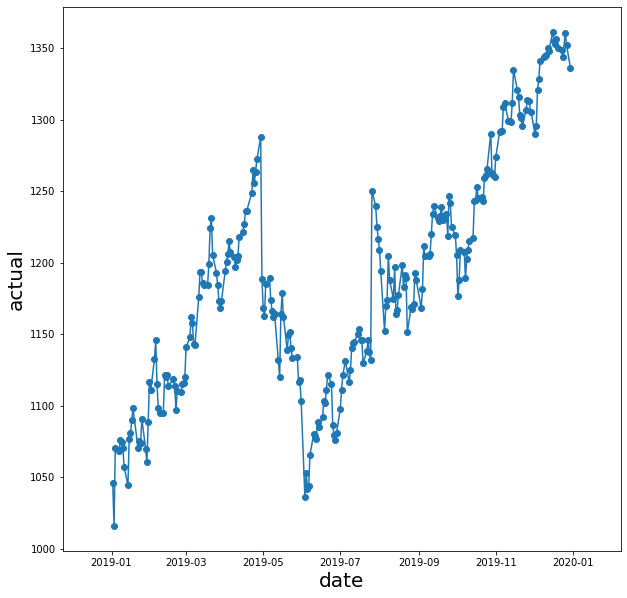

In [42]:
import matplotlib.pyplot as plt
y = df['actual']
x1 = df['date']

plt.scatter(x1,y)
plt.xlabel('date',fontsize=20)
plt.ylabel('actual',fontsize=20)
plt.rcParams["figure.figsize"]=15,10
plt.plot(x1,y)
